# Modifications

- new loss function, eliminate the continent, so we can really focus on the ~ocean~ -> not a good idea; knowing the information on where the continent is matters?
- kernel size to 5? Experiment! -> works well on simpler model
- also want to see the generalization capability of the model -> works well

In [61]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split
tf.random.set_seed(42)

sys.path.insert(0, '../src')

from utils import df_to_xarray,read_xarray,plot_image

In [62]:
# Reading Data
dir_name="../data/data1"
val_dir_name="../data/data2"


chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2=read_xarray(dir_name)



In [96]:
def convert_nan(arr):
    nans=np.isnan(arr)
    min_val=arr[~nans].min()
    #print(min_val)
    arr[nans]=min_val-1
    return arr

def add_dimension(arr):
    images=np.expand_dims(arr, axis=3)
    return images

def scale_image(arr):
    ## Normal
    #arr=(arr-np.mean(arr))/np.std(arr)
    
    ## Min-Max
    # min_val=arr.min()
    # max_val=arr.max()
    # arr=arr/(min_val-max_val)

    ## Image Scale
    min_pixel = arr.min() 
    max_pixel = arr.max()
    new_min = 0
    new_max = 255
    arr = (arr-min_pixel)*(255)/(max_pixel-min_pixel) 
    return arr
  

def preprocess_image_reduced(data,xco2=False):
    if xco2:
        return data
    return scale_image(convert_nan(data))

In [108]:
def inverse_scale_image(arr, df):
    old_min = np.min(df)
    old_max = np.max(df)
    output = arr*(old_max-old_min)/255 + old_min
    return output

In [97]:
#xco2 values are a constant value across the globe, so creating an image layer with constant value for the model
xco2_images=[]
min_xco2=np.min(xco2.XCO2.data)
max_xco2=np.max(xco2.XCO2.data)
new_min=0
new_max=255
print(min_xco2, max_xco2)
print()


for i in xco2.XCO2.data:
    num = (i-min_xco2)*(new_max-new_min)/(max_xco2-min_xco2)+new_min
    tmp = (np.repeat(num,180*360)).reshape(180,-1)
    xco2_images.append(tmp)

xco2_images=np.array(xco2_images)

print("xco2 shape: ")
print(xco2_images.shape, chl.Chl.data.shape)


chl_images=preprocess_image_reduced(chl.Chl.data)
mld_images=preprocess_image_reduced(mld.MLD.data)
sss_images=preprocess_image_reduced(sss.SSS.data)
sst_images=preprocess_image_reduced(sst.SST.data)
xco2_images=preprocess_image_reduced(xco2_images,xco2=True)
pco2_images=preprocess_image_reduced(pco2.pCO2.data)

X = np.stack((chl_images, mld_images, sss_images, sst_images,xco2_images), axis = 1)


340.84854 407.2084

xco2 shape: 
(421, 180, 360) (421, 180, 360)


In [98]:
X=X.reshape((421,180,360,5))
X.shape

(421, 180, 360, 5)

In [99]:
INPUT_SHAPE=X[0].shape
OUTPUT_SHAPE=pco2_images[0].shape

INPUT_SHAPE

(180, 360, 5)

In [100]:
import tensorflow.keras.backend as kb
import tensorflow as tf
from tensorflow.keras import backend as K


def custom_rmse(y_true, y_pred):
#     y_pred = y_pred[y_true != 0]
#     y_true = y_true[y_true != 0]
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    
    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true), axis=-1))



In [101]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=5,activation='elu', padding="SAME")

base_model = keras.models.Sequential([
    DefaultConv2D(filters=64, input_shape=INPUT_SHAPE),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),

    keras.layers.UpSampling2D(size=3),
    keras.layers.BatchNormalization(),
    DefaultConv2D(filters=64),    
    DefaultConv2D(filters=2),
    DefaultConv2D(filters=1,kernel_size=1),
    keras.layers.Reshape(OUTPUT_SHAPE)
   
])



## BEST SO FAR ##

base_model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_194 (Conv2D)          (None, 180, 360, 64)      8064      
_________________________________________________________________
conv2d_195 (Conv2D)          (None, 180, 360, 64)      102464    
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 60, 120, 64)       0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 60, 120, 64)       0         
_________________________________________________________________
conv2d_196 (Conv2D)          (None, 60, 120, 128)      204928    
_________________________________________________________________
conv2d_197 (Conv2D)          (None, 60, 120, 128)      409728    
_________________________________________________________________
up_sampling2d_32 (UpSampling (None, 180, 360, 128)   

In [102]:
base_model.compile(loss=custom_rmse, optimizer="nadam", metrics=["mean_squared_error"])

In [114]:
model_path="../models/base_model/base_model_new.h5"
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

history = base_model.fit(X,pco2_images, epochs=100, validation_data=(X,pco2_images),workers=-1,batch_size=32,callbacks=callbacks)



Epoch 1/100
14/14 [==============================] - 11s 527ms/step - loss: 19.9659 - mean_squared_error: 494.5015 - val_loss: 26.4264 - val_mean_squared_error: 979.5381
Epoch 2/100
14/14 [==============================] - 6s 460ms/step - loss: 26.5675 - mean_squared_error: 904.6233 - val_loss: 20.9560 - val_mean_squared_error: 539.1412
Epoch 3/100
14/14 [==============================] - 6s 461ms/step - loss: 19.6132 - mean_squared_error: 483.2688 - val_loss: 18.4748 - val_mean_squared_error: 436.7166
Epoch 4/100
14/14 [==============================] - 6s 459ms/step - loss: 18.9437 - mean_squared_error: 454.3122 - val_loss: 19.7360 - val_mean_squared_error: 479.9722
Epoch 5/100
14/14 [==============================] - 6s 461ms/step - loss: 18.5683 - mean_squared_error: 439.8395 - val_loss: 16.9600 - val_mean_squared_error: 376.2731
Epoch 6/100
14/14 [==============================] - 6s 463ms/step - loss: 17.9612 - mean_squared_error: 412.3351 - val_loss: 19.8302 - val_mean_squared_e

In [115]:
best_model = tf.keras.models.load_model('../models/base_model/base_model_new.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_image=best_model.predict(X[419:421],verbose=1)

1/1 [==============================] - 0s 423ms/step


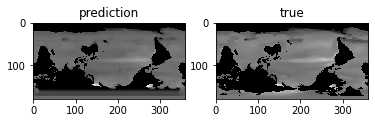

<Figure size 432x288 with 0 Axes>

In [116]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2)


axis[0].imshow(np.squeeze(predicted_image[1]), cmap="gray", interpolation="nearest")
axis[0].set_title("prediction")
axis[1].imshow(np.squeeze(pco2_images[419:421][1]), cmap="gray", interpolation="nearest")
axis[1].set_title("true")

plt.show()
plt.savefig('base_model_prediction.png')

In [117]:
arr=predicted_image[1]
output=inverse_scale_image(arr, pco2.pCO2.data)

np.sqrt(np.mean((pco2.pCO2.data[419:421][1]-output)**2))


54.26488754782829

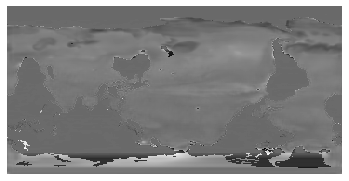

In [118]:
difference=np.squeeze(pco2_images[419:421][1])-np.squeeze(predicted_image[0])
plot_image(difference)

In [119]:

#kernel_size matters, 2 does not work

model1 = keras.models.Sequential([
    DefaultConv2D(filters=64, input_shape=INPUT_SHAPE),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Dropout(0.3),

    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Dropout(0.3),

    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),

    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),

    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=2),
    DefaultConv2D(filters=1,kernel_size=1),
    keras.layers.Reshape(OUTPUT_SHAPE)
   
])

model1.summary()


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_201 (Conv2D)          (None, 180, 360, 64)      8064      
_________________________________________________________________
conv2d_202 (Conv2D)          (None, 180, 360, 64)      102464    
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 60, 120, 64)       0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 60, 120, 64)       0         
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 60, 120, 128)      204928    
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 60, 120, 128)      409728    
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 20, 40, 128)     

In [120]:
model1.compile(loss=custom_rmse, optimizer="nadam", metrics=["mean_squared_error"])

In [ ]:
model_path="../models/base_model/reduceddim_model1.h5"
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

history = model1.fit(X,pco2_images, epochs=100, validation_data=(X,pco2_images),workers=-1,batch_size=32,callbacks=callbacks)




Epoch 1/100
14/14 [==============================] - 9s 556ms/step - loss: 63.0435 - mean_squared_error: 4522.2768 - val_loss: 62.6599 - val_mean_squared_error: 4464.8701
Epoch 2/100
14/14 [==============================] - 7s 513ms/step - loss: 62.5428 - mean_squared_error: 4447.8298 - val_loss: 62.6450 - val_mean_squared_error: 4460.6562
Epoch 3/100
14/14 [==============================] - 7s 512ms/step - loss: 62.6868 - mean_squared_error: 4466.7698 - val_loss: 62.6168 - val_mean_squared_error: 4456.3232
Epoch 4/100
14/14 [==============================] - 7s 513ms/step - loss: 62.6015 - mean_squared_error: 4453.4453 - val_loss: 62.5884 - val_mean_squared_error: 4451.9751
Epoch 5/100
14/14 [==============================] - 7s 513ms/step - loss: 62.5416 - mean_squared_error: 4446.8417 - val_loss: 62.5602 - val_mean_squared_error: 4447.6362
Epoch 6/100
14/14 [==============================] - 7s 513ms/step - loss: 62.3974 - mean_squared_error: 4425.2514 - val_loss: 62.5319 - val_mean

In [77]:
best_model = tf.keras.models.load_model('../models/base_model/reduceddim_model1.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_image=best_model.predict(X[419:421],verbose=1)

1/1 [==============================] - 0s 399ms/step


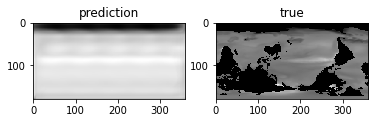

In [78]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2)


axis[0].imshow(np.squeeze(predicted_image[1]), cmap="gray", interpolation="nearest")
axis[0].set_title("prediction")
axis[1].imshow(np.squeeze(pco2_images[419:421][1]), cmap="gray", interpolation="nearest")
axis[1].set_title("true")

plt.show()